In [1]:
%load_ext autoreload

%autoreload 2
from astropy.io import fits as fits
import matplotlib.pyplot as plt
import pickle
import sys
import emcee
import numpy as np
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from astropy.table import Table, QTable, hstack, vstack
from astropy import units as u
import corner
cosmo_astropy = FlatLambdaCDM(H0=71.0, Om0=0.265, Ob0 = 0.0448)
import iminuit
from iminuit import Minuit
cosmo_astropy.critical_density(0.4).to(u.Msun / u.Mpc**3).value


sys.path.append('../../modeling')
import CL_COUNT_modeling_completeness as comp
import CL_COUNT_modeling_purity as pur
import CL_COUNT_modeling_halo_mass_function as hmf
import CL_COUNT_modeling_richness_mass_relation as rm_relation
import CL_MASS_cluster_mass as cl_mass
import CL_COUNT_cluster_abundance as cl_count
import CL_COUNT_class_likelihood as likelihood
import CL_LENSING_cluster_lensing as cl_lensing

In [2]:
name = '../../data/matched_pairs_Mfofcut.fits'
dat = fits.open(name)
dat_open= dat[1].data

In [3]:
table = Table()
table['richness'] = dat_open['cat1_richness']
table['M200c'] = dat_open['cat2_M200c']
table['redshift'] = dat_open['cat1_ztrue_cg']

In [4]:
richness_min = 5
table_cut = table[(table['M200c'] > 2e13)*(table['richness'] > richness_min)*(table['redshift'] < 1)*(table['redshift'] > .2)]

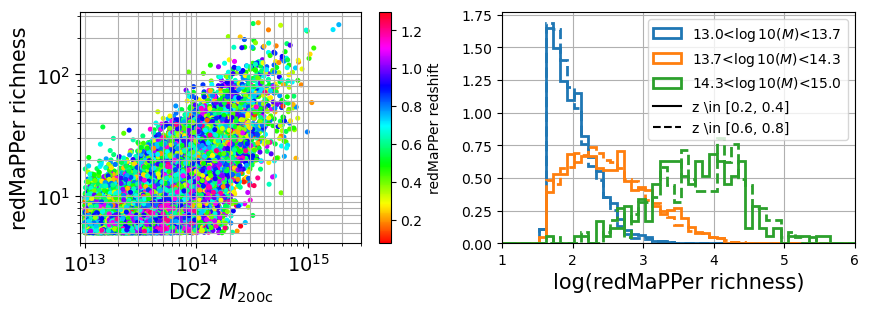

In [5]:
plt.figure(figsize=(10,3))
plt.subplot(121)
plt.tick_params(axis='both', which = 'major', labelsize= 14)
plt.grid(True, which="both")
plt.scatter( table['M200c'], table['richness'],c=table['redshift'], s=7, cmap='hsv')
plt.xlim(9e12, 3e15)
plt.colorbar(label='redMaPPer redshift')
plt.yscale('log')
plt.xscale('log')
plt.ylabel(r'redMaPPer richness', fontsize=15)
plt.xlabel(r'DC2 $M_{\rm 200c}$', fontsize=15)
plt.grid(True)
log_mass_index = np.linspace(13, 15, 4)
log_mass_bins = [[log_mass_index[i], log_mass_index [i+1]] for i in range(len(log_mass_index)-1)]
plt.subplot(122)
plt.xlabel(r'log(redMaPPer richness)', fontsize=15)
plt.grid(True, which="both")
bin_lambda = np.linspace(0, 10, 100)
color = ['C'+str(i) for i in range(20)]
for i, log_mass_bin in enumerate(log_mass_bins):
    mask_z_1 = (table_cut['redshift'] > 0.2)*(table_cut['redshift'] < 0.4)
    plt.hist(np.log(table_cut['richness'][(table_cut['M200c'] > 10**log_mass_bin[0])*(table_cut['M200c'] < 10**log_mass_bin[1])*mask_z_1]), 
             density=True, histtype='step', lw=2, label = f'{log_mass_bin[0]:.1f}<$\log10(M)$<{log_mass_bin[1]:.1f}', bins=bin_lambda,
            color = color[i])
    
    mask_z_2 = (table_cut['redshift'] > 0.6)*(table_cut['redshift'] < 0.8)
    plt.hist(np.log(table_cut['richness'][(table_cut['M200c'] > 10**log_mass_bin[0])*(table_cut['M200c'] < 10**log_mass_bin[1])*mask_z_2]), 
             density=True, histtype='step', lw=2,  bins=bin_lambda, ls='--',color = color[i])

plt.plot([],[], '-k', label='z \in [0.2, 0.4]')
plt.plot([],[], '--k', label='z \in [0.6, 0.8]')
plt.legend()
plt.xlim(1, 6)
plt.savefig('../../fig/match_redMaPPer_cosmoDC2_lens_catalog.png',bbox_inches='tight', dpi=300)

In [6]:
import scipy
u = np.linspace(-50, 50, 2000)
pu = 0.5*(1 + scipy.special.erf(u))
def p_f(x):
    return np.interp(x, u, pu, left=None, right=None)

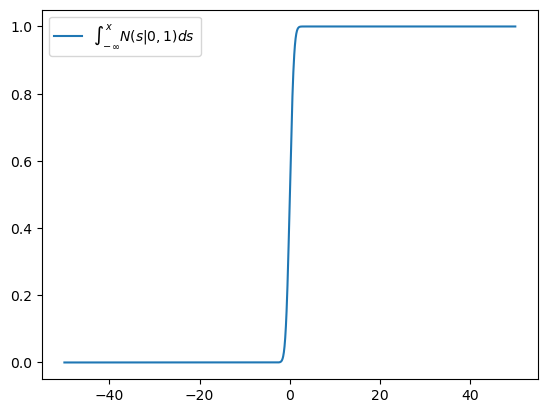

In [7]:
plt.plot(u, pu, label = r'$\int_{-\infty}^x N(s|0,1)ds$')
plt.legend(fontsize=10)

In [8]:
def lnLikelihood(p):
    proxy_mu0, proxy_muz, proxy_mulog10m, proxy_sigma0, proxy_sigmaz, proxy_sigmalog10m = p
    params = np.log10(10**14.2), .4, proxy_mu0, proxy_muz, proxy_mulog10m, proxy_sigma0, proxy_sigmaz, proxy_sigmalog10m 
    mu = rm_relation.proxy_mu_f(np.log10(table_cut['M200c']), table_cut['redshift'],  params)
    sigma= rm_relation.proxy_sigma_f(np.log10(table_cut['M200c']), table_cut['redshift'],  params)
    pdf_lnlambda = table_cut['richness']*rm_relation.pdf_richness_mass_relation(table_cut['richness'], np.log10(table_cut['M200c']), table_cut['redshift'], params)
    normalx = np.array((np.log(richness_min) - mu)/(np.sqrt(2)*sigma))
    normalp =  p_f(normalx)
    pdf_lnlambda = pdf_lnlambda/(1-normalp)
    if np.isnan(np.sum(np.log(pdf_lnlambda))): return -np.inf
    return np.sum(np.log(pdf_lnlambda))

In [23]:
initial = [3.15554779, -0.01047953,  2.1415984 ,  0.53798303, 0 ,
       0]
lnLikelihood(initial)

-9540.354423092118

In [24]:
from multiprocessing import Pool
nwalker=20
pos=.001*np.random.randn(nwalker,6) + initial
#with Pool() as pool:
sampler = emcee.EnsembleSampler(nwalker, 6, lnLikelihood, )#pool=pool)
sampler.run_mcmc(pos, 600, progress=True);
flat_samples1 = sampler.get_chain(discard=10, thin=3, flat=True)

100%|██████████| 600/600 [02:14<00:00,  4.45it/s]


[ 3.10147452 -0.01975221  2.33387671  0.56885547 -0.10269881  0.00910488]


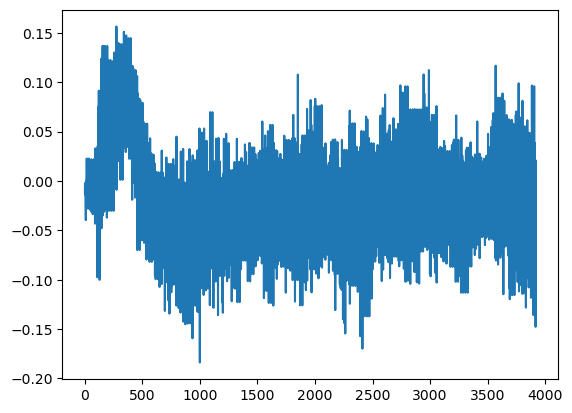

In [25]:
plt.plot(flat_samples1[:,1])
print(np.mean(flat_samples1[3000:], axis=0))
np.save('fiducial.pkl',flat_samples1[3000:],)

In [26]:
p = np.mean(flat_samples1[3500:], axis=0)
params = [np.log10(10**14.2), .4]
params = params + list(p)

0.17651406560850547
0.9623405348072372
0.9999952058014155


(0.0, 2.5)

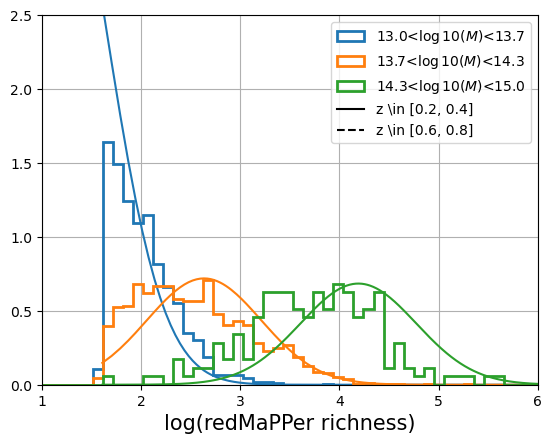

In [27]:
plt.xlabel(r'log(redMaPPer richness)', fontsize=15)
plt.grid(True, which="both")
bin_lambda = np.linspace(0, 10, 100)
color = ['C'+str(i) for i in range(20)]
richness = np.linspace(5, 500, 1000)
log_mass_index = np.linspace(13, 15, 4)
log_mass_bins = [[log_mass_index[i], log_mass_index [i+1]] for i in range(len(log_mass_index)-1)]
for i, log_mass_bin in enumerate(log_mass_bins):
    
    mean_log_mass = np.mean(log_mass_bin)
    mean_z = 0.3
    mask_z_1 = (table_cut['redshift'] > 0.2)*(table_cut['redshift'] < 0.4)
    
    #model
    mu = rm_relation.proxy_mu_f(mean_log_mass, mean_z,   params)
    sigma= rm_relation.proxy_sigma_f(mean_log_mass, mean_z,  params)
    pdf_lnlambda = richness*rm_relation.pdf_richness_mass_relation(richness, mean_log_mass, mean_z, params)
    normalx = np.array((np.log(richness_min) - mu)/(np.sqrt(2)*sigma))
    normalp =  p_f(normalx)
    print((1-normalp))
    pdf_lnlambda = pdf_lnlambda/(1-normalp)
    plt.plot(np.log(richness), pdf_lnlambda)
    #
    plt.hist(np.log(table_cut['richness'][(table_cut['M200c'] > 10**log_mass_bin[0])*(table_cut['M200c'] < 10**log_mass_bin[1])*mask_z_1]), 
             density=True, histtype='step', lw=2, label = f'{log_mass_bin[0]:.1f}<$\log10(M)$<{log_mass_bin[1]:.1f}', bins=bin_lambda,
            color = color[i])
    
#     mean_z = 0.7
#     mask_z_2 = (table_cut['redshift'] > 0.6)*(table_cut['redshift'] < 0.8)
#     plt.hist(np.log(table_cut['richness'][(table_cut['M200c'] > 10**log_mass_bin[0])*(table_cut['M200c'] < 10**log_mass_bin[1])*mask_z_2]), 
#              density=True, histtype='step', lw=2,  bins=bin_lambda, ls='--',color = color[i])
    
plt.plot([],[], '-k', label='z \in [0.2, 0.4]')
plt.plot([],[], '--k', label='z \in [0.6, 0.8]')
plt.legend()
plt.xlim(1, 6)
plt.ylim(0, 2.5)

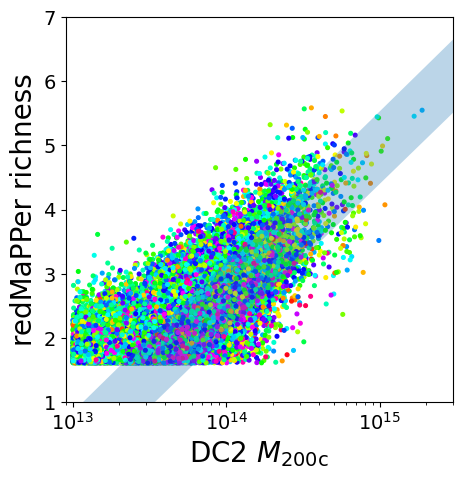

In [14]:
plt.figure(figsize=(5,5))
plt.tick_params(axis='both', which = 'major', labelsize= 14)
#plt.grid(True, which="both")
plt.scatter( table['M200c'], np.log(table['richness']),c=table['redshift'], s=7, cmap='hsv')
m = np.linspace(1e13, 3e15, 10)
mu = rm_relation.proxy_mu_f(np.log10(m) , .6,  params,)
sigma = rm_relation.proxy_sigma_f(np.log10(m) , .6,  params,)
plt.fill_between(m, mu+ sigma, mu- sigma ,alpha=.3)
#plt.colorbar().set_label(label=r'redshift',size=20,)
plt.ylim(1, 7)
plt.xlim(9e12, 3e15)
#plt.yscale('log')
plt.xscale('log')
plt.ylabel(r'redMaPPer richness', fontsize=20)
plt.xlabel(r'DC2 $M_{\rm 200c}$', fontsize=20)
radius = np.linspace(4, 20, 100)